In [1]:
import pandas as pd
import numpy as np
from joblib import dump, load
import time
import datetime
import operator

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import callbacks

from matplotlib import pyplot as plt

In [2]:
%load_ext tensorboard

### Some useful functions

In [3]:
def get_confusion_matrix(true_pos, false_pos, true_neg, false_neg):
    conf_matrix = np.array([
                            [true_pos, false_pos],
                            [false_neg, true_neg]
                           ])
    
    return pd.DataFrame(conf_matrix, columns=['1', '0'], index=['1', '0'])

In [4]:
def learning_plot(model, metric):
    
    fig = plt.figure()
    
    fig = plt.plot(model.history[metric], color='black')
    fig = plt.plot(model.history['val_'+metric], color='blue')

    plt.title('Changes in {} over training run'.format(metric))
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    
    plt.legend(['train', 'val'], loc='upper right')
    
    return fig

In [5]:
def learning_recall(model, positives_flag=True):
    
    if positives_flag:
        recall = [tp / (tp+fn) for tp, fn in zip(model.history['true_positives'], model.history['false_negatives'])]
        val_recall = [tp / (tp+fn) for tp, fn in zip(model.history['val_true_positives'], model.history['val_false_negatives'])]
        recall_type = 'positive'
    else:
        recall = [tn / (tn+fp) for tn, fp in zip(model.history['true_negatives'], model.history['false_positives'])]
        val_recall = [tn / (tn+fp) for tn, fp in zip(model.history['val_true_negatives'], model.history['val_false_positives'])]
        recall_type = 'negative'
        
    fig = plt.figure()
    
    fig = plt.plot(recall, color='black')
    fig = plt.plot(val_recall, color='blue')
    
    plt.title('Changes in {} recall rate over training run.'.format(recall_type))
    plt.xlabel('Epoch')
    plt.ylabel('{} recall rate'.format(recall_type))
    
    return fig

In [6]:
def random_search_models(num_models, input_dims, compile_metrics, seed):
    
    np.random.seed(seed)
    
    all_models = []
    
    for m in range(num_models): 
        
        num_hidden_layers = np.random.randint(1, 11)
        all_models.append(build_model(num_hidden_layers, input_dims, compile_metrics))
    
    return all_models

def build_layers(num_layers, input_dims):

    layers = []
    
    for i in range(num_layers):
        
        num_units = np.random.randint(2, 27)
        reg_val = 10**(-4*np.random.rand())
        if i==0:
            layers.append(Dense(
                                units = num_units,
                                input_dim = input_dims,
                                activation = 'relu',
                                kernel_regularizer = l2(l2=reg_val)
                               ))
        else:
            layers.append(Dense(
                                units = num_units,
                                activation = 'relu',
                                kernel_regularizer = l2(l2=reg_val)
                               ))
    reg_val = 10**(-4*np.random.rand())
    layers.append(Dense(
                        units = 1,
                        activation = 'sigmoid',
                        kernel_regularizer = l2(l2=reg_val)
                       ))
    return layers

def build_model(num_hidden_layers, input_dims, compile_metrics):

    model = Sequential()
    
    layers = build_layers(num_hidden_layers, input_dims)
    for l in layers:
        model.add(l)
    
    learning_rate = 10**(-4*np.random.rand())
    model.compile(optimizer = Adam(learning_rate), loss='binary_crossentropy', metrics=[compile_metrics])
    
    return model

In [7]:
def get_best_models(model_list, metric, descending, num_models):
    
    m_tuples = []
    for model, history in model_list:
        m_tuples.append((model, history, history.history[metric][-1]))
        
    m_tuples.sort(key=operator.itemgetter(2), reverse=descending)
    
    if num_models:
        return m_tuples[:num_models]
    else:
        return m_tuples

### Load and prepare data

In [8]:
df = pd.read_csv('jazz.csv', sep='|')

In [9]:
# Define features to analyze
features = [
            'danceability',
            'energy',
            'speechiness',
            'acousticness',
            'instrumentalness',
            'liveness',
            'valence',
            'num_samples',
            'end_of_fade_in',
            'loudness',
            'tempo',
            'key',
            'mode',
            'bars_num',
            'bars_duration_var',
            'beats_duration_var',
            'sections_num',
            'sections_duration_mean',
            'sections_duration_var',
            'loudness_var',
            'tempo_var',
            'key_var',
            'mode_var',
            'segments_duration_var',
            'segments_duration_mean',
            'pitches_mean',
            'pitches_var',
            'timbre_mean',
            'timbre_var',
            'tatums_duration_var'
           ]

df = df[features+['label']]

# Shuffle data to ungroup class rows
df = df.sample(frac=1, random_state=12).reset_index(drop=True)

In [10]:
df[df['label']==1].shape

(1560, 31)

Split dataset into training, validation, and test. 60/20/20 gives ~936 positive training samples, and ~312 each of positive validation and test samples. Quite small, but hopefully big enough to be meaningful.

In [11]:
X = df[features].copy()
Y = df['label'].copy()

X_train, X_test, y_train, y_test = train_test_split(
                                                    X,
                                                    Y, 
                                                    stratify = Y,
                                                    test_size = 0.2,
                                                    random_state = 42
                                                   )

# Start building model

In [12]:
# First fit how to scale data for the model
pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('imputer', SimpleImputer(strategy='median'))])

scale_model = pipeline.fit(X_train)
X_train = scale_model.transform(X_train)
X_test = scale_model.transform(X_test)

# Save for later use
dump(scale_model, 'scaler.joblib') 

['scaler.joblib']

In [13]:
logdir = 'logs/scalars/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = callbacks.TensorBoard(log_dir=logdir)

metrics = [
           tfk.metrics.Precision(),
           tfk.metrics.TruePositives(),
           tfk.metrics.TrueNegatives(),
           tfk.metrics.FalsePositives(),
           tfk.metrics.FalseNegatives(),
           tfk.metrics.AUC(curve='PR')
          ]

models = random_search_models(num_models=25, input_dims=len(features), compile_metrics=metrics, seed=42)

model_list = []

for i, model in enumerate(models):

    training_history = model.fit(
                                 X_train,
                                 y_train,
                                 batch_size = 128,
                                 verbose = 0,
                                 epochs = 500,
                                 validation_split = 0.2,
                                 callbacks=[callbacks.TensorBoard(log_dir=logdir+'-'+str(i))],
                                )
    model_list.append((model, training_history))
    
    print('Average validation loss for model ', str(i+1), ': ', np.average(training_history.history['val_loss']))

Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Average validation loss for model  1 :  1.2035179035663606
Average validation loss for model  2 :  0.7794862763881684
Average validation loss for model  3 :  0.7491164590120316
Average validation loss for model  4 :  0.7110158059597015
Average validation loss for model  5 :  0.6903858382701874
Average validation loss for model  6 :  0.7380453287363052
Average validation loss for model  7 :  1.1316582872867584
Average validation loss for model  8 :  0.5489197136163712
Average validation loss for model  9 :  0.6323059469461441
Average validation loss for model  10 :  0.6871961886882783
Average validation loss for model  11 :  0.5344650441408157
Average validation loss for model  12 :  0.7783581628799439
Average validation loss for model  13 :  2.164799843549728
Average validation loss for model  14 :  0.5384274446964263
Average validation loss for model  15 :  0.8239258939027786
Average validation loss for model  16 

In [26]:
%tensorboard --logdir logs/scalars

Reusing TensorBoard on port 6006 (pid 444), started 0:01:35 ago. (Use '!kill 444' to kill it.)

In [17]:
# Get five best models to evaluate on Tensorboard
model_list_sorted = get_best_models(model_list, 'val_auc', descending=True, num_models=5)

In [34]:
best_model = model_list_sorted[0][0]
best_history = model_list_sorted[0][1]

# Evaluate model on validation set

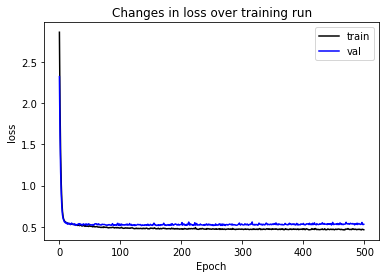

In [35]:
learning_plot(best_history, 'loss')

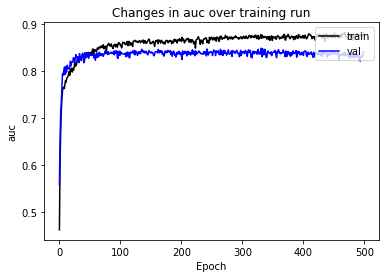

In [36]:
learning_plot(best_history, 'auc')

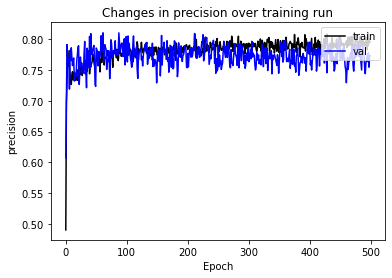

In [37]:
learning_plot(best_history, 'precision')

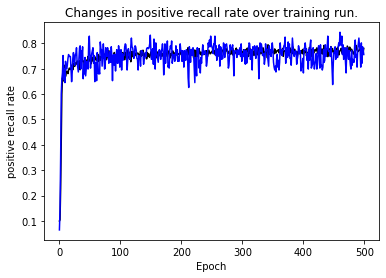

In [38]:
learning_recall(best_history, True)

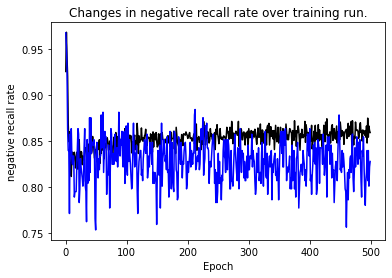

In [39]:
learning_recall(best_history, False)

In [40]:
loss = best_history.history['loss'][-1]
val_loss = best_history.history['val_loss'][-1]
print('Loss for training set is {}, while loss for validation set is {}. This gives a difference of {}'\
      .format(
              round(loss,4),
              round(val_loss,4), 
              round(val_loss-loss, 4))
             )

Loss for training set is 0.4655, while loss for validation set is 0.5318. This gives a difference of 0.0663


In [41]:
auc = best_history.history['auc'][-1]
val_auc = best_history.history['val_auc'][-1]
print('AUC for training set is {}, while AUC for validation set is {}. This gives a difference of {}'\
      .format(round(auc, 2), round(val_auc, 2), round(auc-val_auc,2)))

AUC for training set is 0.88, while AUC for validation set is 0.84. This gives a difference of 0.04


In [42]:
true_positives_val = best_history.history['val_true_positives'][-1]
false_positives_val = best_history.history['val_false_positives'][-1]
true_negatives_val = best_history.history['val_true_negatives'][-1]
false_negatives_val = best_history.history['val_false_negatives'][-1]

val_conf_matrix = get_confusion_matrix(
                                       true_positives_val,
                                       false_positives_val,
                                       true_negatives_val,
                                       false_negatives_val
                                      )

print('Confusion_matrix:\n{}'.format(val_conf_matrix))

Confusion_matrix:
       1      0
1  198.0   58.0
0   64.0  279.0


In [43]:
print('True recall rate is {}'\
      .format(round(val_conf_matrix.loc['1', '1']/(val_conf_matrix.loc['1', '1']+val_conf_matrix.loc['0', '1']),2)))
print('Precision is {}'.format(best_history.history['val_precision'][-1]))

True recall rate is 0.76
Precision is 0.7734375


Looks very promising on validation set! Let's check test set

In [44]:
loss_test, precision_test, true_positives_test, true_negatives_test, false_positives_test, false_negatives_test, auc_test = best_model.evaluate(X_test, y_test)

24/24 [==============================] - 0s 1ms/step - loss: 0.5367 - precision: 0.7581 - true_positives: 235.0000 - true_negatives: 362.0000 - false_positives: 75.0000 - false_negatives: 77.0000 - auc: 0.8141


In [45]:
print('AUC for test set is {}.'.format(round(auc_test,2)))

AUC for test set is 0.81.


In [46]:
confusion_matrix = get_confusion_matrix(
                                        true_positives_test,
                                        false_positives_test,
                                        true_negatives_test,
                                        false_negatives_test
                                       )

In [47]:
print(confusion_matrix)

       1      0
1  235.0   75.0
0   77.0  362.0


In [48]:
print(
      'True recall rate is {}'\
      .format(round(
                    confusion_matrix.loc['1', '1']/
                    (confusion_matrix.loc['1', '1']+confusion_matrix.loc['0', '1']),
                    2
                   )
             )
     )
print('Precision is {}'.format(round(precision_test,2)))

True recall rate is 0.75
Precision is 0.76


# Save model

In [49]:
best_model.save('jazz_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: jazz_model\assets
